In [1]:
%load_ext autoreload
%autoreload 2   

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qdm.server.comms import *
from qdm.measurements.esr_server import ESR
from qdm.routines.esr_bnorm_sweep import esr_bnorm_sweep

C:\qdm-control\src\qdm\fitting\image_fitting\scipyfit.py:35: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # auto detects jupyter


In [9]:
# Set the rf frequency and power
await set_rf(freq=2870.5, power=-36, output=1)

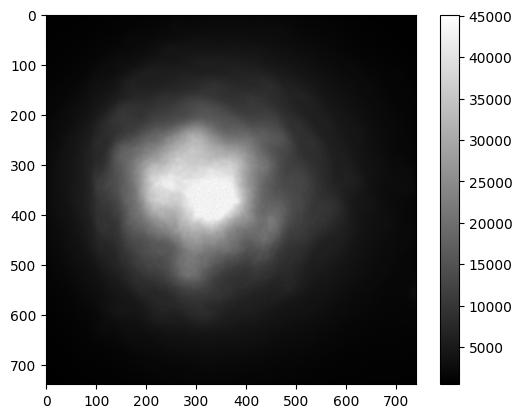

{'error': None, 'response': 'set attr'}

In [20]:
# Get a frame to check the camera and laser is working
await sys_query(dev='SYS', cmd='laser_output', args=[1])
await set_cam(exposure = 0.1, 
              bin = (1, 1), 
              trigger_mode = "int", 
              image_size=(740, 740))
# Get the image size
img_size = (await sys_query(dev='cam', cmd='get_attr', attr="data_size"))['data']

# get a single frame
image = await sys_query(dev='cam', cmd='get_frame', kwargs={"num_frames": 1})

# Plot the image
plt.figure()
plt.imshow(image.reshape((img_size[0], img_size[1])), cmap='gray', interpolation='none')
plt.colorbar()
plt.show()
await sys_query(dev='SYS', cmd='laser_output', args=[0])


## Now for sweeping the bnorm

In [ ]:
# Set the magnetic field
await set_mag(bnorm=-200, theta=54.7, phi=45)


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


pos: 2071.77 ± 1.09 (MHz)
FWHM: 18.7 ± 3.71 (MHz)
contrast: -0.296 ± 0.03 (%)
amplitude: -9526.7 ± 1119.53 (Mcps)
counts: 32143.500 (Mcps)
Sensitivity fit: 9.67 (nT/√Hz)
Sensitivity data: 0.59 (nT/√Hz)
signal magnitude: 0.29
noise: 5.71e-02
SNR: 5.16


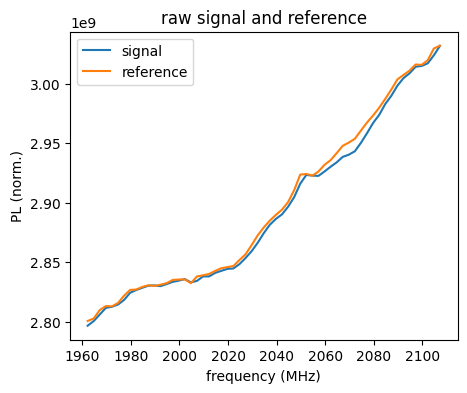

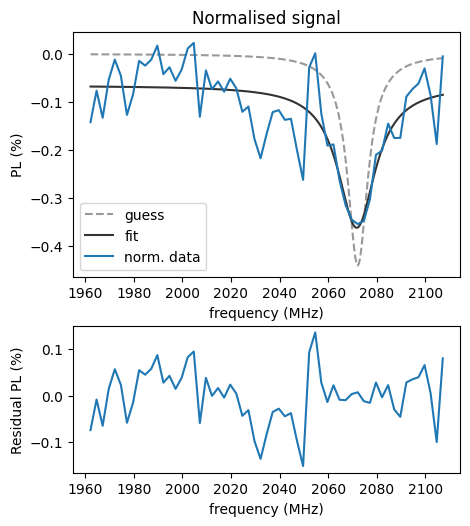

In [27]:
# Define the broad ODMR measurement and test it

Broad_ODMR = ESR(
            int_time = 30e-3,
            avg_per_point = 1,
            freq_center= 2032.2,
            freq_range = 150,
            freq_num = 61,
            rf_power = -26,
            esr_type= "cw",
            ref_bool = True,
            ref_type = "no_rf",
            laser_dur = 300e-6,
            rf_dur = 300e-9) 


await Broad_ODMR.start(num_sweeps = 3 , continue_meas = False) # start the measurement
await Broad_ODMR.plot_spectrum(remove_start=2, bfit=True, peak_neg=True)

100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


pos: 2069.33 ± 0.30 (MHz)
FWHM: 3.0 ± 1.17 (MHz)
contrast: -0.803 ± 0.20 (%)
amplitude: -22516.9 ± 5604.55 (Mcps)
counts: 28056.088 (Mcps)
Sensitivity fit: 0.61 (nT/√Hz)
Sensitivity data: 0.41 (nT/√Hz)
signal magnitude: 0.80
noise: 1.40e-01
SNR: 5.68


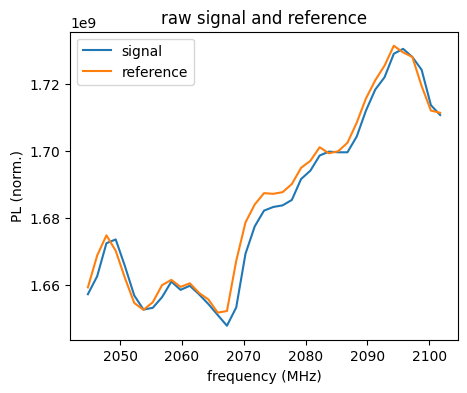

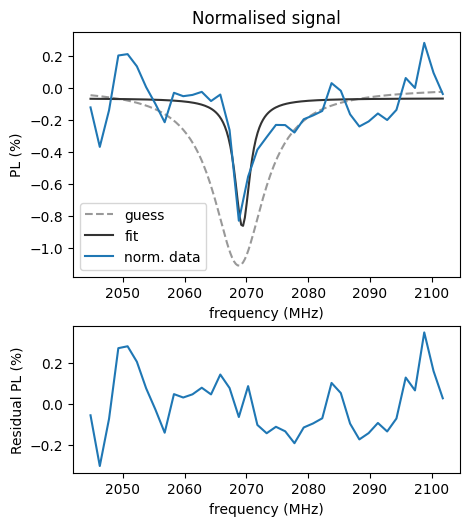

In [28]:
# test the narrow ODMR
Narrow_ODMR = ESR(
            int_time = 30e-3,
            avg_per_point = 1,
            freq_center= 2071.77,
            freq_range = 60,
            freq_num = 41,
            rf_power = -26,
            esr_type= "cw",
            ref_bool = True,
            ref_type = "no_rf",
            laser_dur = 300e-6,
            rf_dur = 300e-9) 

await Narrow_ODMR.start(num_sweeps = 2, continue_meas = False) # start the measurement

await Narrow_ODMR.plot_spectrum(remove_start=2, bfit=True, peak_neg=True)


In [25]:
# Set the magnetic field
await set_mag(bnorm=30, theta=125, phi=-135)

In [29]:
# Set the magnetic field
await sys_query(dev="magnet", cmd="get_current")

{'error': None,
 'response': 'get attr',
 'data': [[-0.9241, 0.9386, 0.7274],
  [-17.37308, -17.373486, -17.217558000000004],
  [30.002, 125.021, -134.999]]}

In [ ]:
# estimate the total duration
# There will be more time for the broad odmr and the sweeping of the field
#b_list = np.linspace(160, 180, 10)
b_list = [ -6, -10, -15, -20, -25, -30, -35, -60, -150, -200, -250, -300]
narrow_num = 750
# b_num = int(1+ abs((b_max - b_min)/b_step))
b_num = len(b_list)
total_time = ((Narrow_ODMR.int_time * 2*Narrow_ODMR.freq_num * narrow_num)*b_num)/3600
print(f"Total time: {total_time} hours")

In [ ]:
# Perform the b sweep
await esr_bnorm_sweep(b_list=b_list,
                theta = 54.7,
                phi = 45,
                Broad_ODMR = Broad_ODMR,
                broad_num = 5,
                Narrow_ODMR = Narrow_ODMR,
                narrow_num = narrow_num,
                remove_start = 2,
                peform_pixel_fit=True)


In [ ]:
(await sys_query(dev="sys", cmd="get_attr", attr="sequence_params"))["data"]

In [ ]:
# close all of the device
await sys_query(dev='SYS', cmd='shutdown')

In [ ]:
await sys_query(dev='SYS', cmd='get_attr', attr='save_dir', args=[0])